In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
from sklearn.cross_decomposition import PLSRegression
from scipy import stats
import os
from ChemUtils import GlobalStandardScaler, EmscScaler
import random
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import median_abs_deviation
import matplotlib.pyplot as plt
from sys import stdout
from scipy.stats import f
from sklearn.model_selection import cross_val_predict
import obspy
from obspy.signal.detrend import polynomial
import seaborn as sns 
import scipy.io as sio
from joblib import load
import peval 

import tensorflow as tf
from livelossplot import PlotLossesKerasTF
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv1D, Reshape
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


In [2]:
# read in the data from the pickle file
with open('/root/autodl-tmp/vertigo/data/2_outlier_removal.pkl', 'rb') as f:
    df_outlier = pickle.load(f)

# df

with open('/root/autodl-tmp/vertigo/data/2_clean_data.pkl', 'rb') as f:
    df_clean = pickle.load(f)

with open('/root/autodl-tmp/vertigo/data/2_outlier_removal_pls.pkl', 'rb') as f:
    df_clean_pls = pickle.load(f)

df = df_clean.copy()
# print(df.shape)

* Approach 1: Hybrid Modeling (PLS2 for TA/Firmness + PLS for Brix)

* Approach 2: Individual PLS Models

=== Approach 1: Hybrid Modeling ===

Finding optimal components for PLS2 (TA + Firmness)...


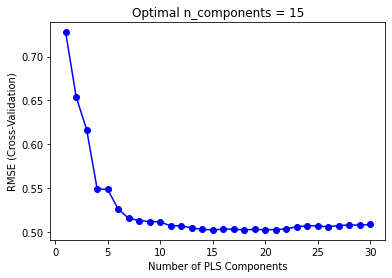


Finding optimal components for Brix...


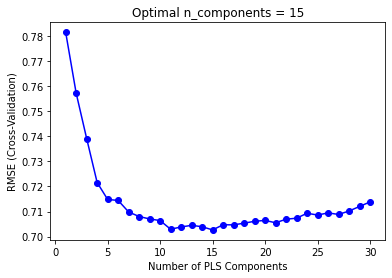


=== Approach 2: Individual Models ===

Finding optimal components for TA...


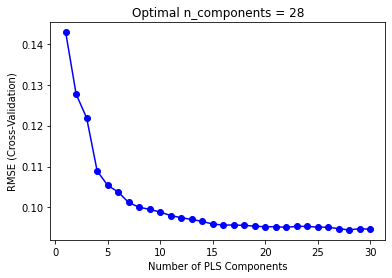


Finding optimal components for Firmness (kg)...


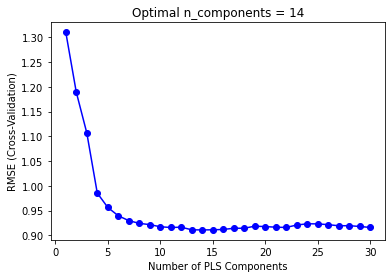


Finding optimal components for Brix...


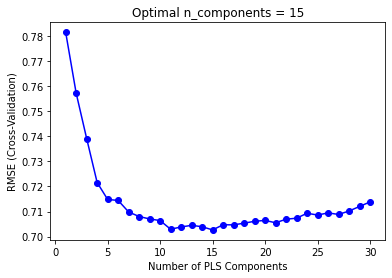

In [3]:
# Load data and prepare targets
spectral_cols = [col for col in df.columns if 'GHz' in col]
quality_attrs = ['Brix', 'TA', 'Firmness (kg)']

X = df[spectral_cols]
y = df[quality_attrs]

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, random_state=42, shuffle=True)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Function to find optimal n_components
def find_optimal_components(X, y, max_components=30):
    rmse_scores = []
    for n in range(1, max_components+1):
        pls = PLSRegression(n_components=n)
        scores = -cross_val_score(pls, X, y, 
                                 cv=10, 
                                 scoring='neg_root_mean_squared_error')
        rmse_scores.append(np.mean(scores))
    
    optimal_n = np.argmin(rmse_scores) + 1  # +1 because components start at 1
    plt.plot(range(1, max_components+1), rmse_scores, 'bo-')
    plt.xlabel('Number of PLS Components')
    plt.ylabel('RMSE (Cross-Validation)')
    plt.title(f'Optimal n_components = {optimal_n}')
    plt.show()
    return optimal_n

# Approach 1: Hybrid Modeling (PLS2 for TA/Firmness + PLS for Brix)
print("=== Approach 1: Hybrid Modeling ===")

# Find optimal components for PLS2 (TA + Firmness)
print("\nFinding optimal components for PLS2 (TA + Firmness)...")
optimal_pls2 = find_optimal_components(X_train_scaled, y_train[['TA', 'Firmness (kg)']])
pls2 = PLSRegression(n_components=optimal_pls2)
pls2.fit(X_train_scaled, y_train[['TA', 'Firmness (kg)']])

# Find optimal components for Brix
print("\nFinding optimal components for Brix...")
optimal_brix = find_optimal_components(X_train_scaled, y_train['Brix'])
pls_brix = PLSRegression(n_components=optimal_brix)
pls_brix.fit(X_train_scaled, y_train['Brix'])

# Approach 2: Individual PLS Models
print("\n=== Approach 2: Individual Models ===")

# Find optimal components for each target
targets = ['TA', 'Firmness (kg)', 'Brix']
individual_models = {}

for target in targets:
    print(f"\nFinding optimal components for {target}...")
    optimal_n = find_optimal_components(X_train_scaled, y_train[target])
    pls = PLSRegression(n_components=optimal_n)
    pls.fit(X_train_scaled, y_train[target])
    individual_models[target] = pls

# Evaluation function
def evaluate_model(model, X_test, y_test, target_name, multioutput=False):
    y_pred = model.predict(X_test)
    if multioutput:
        y_pred = y_pred[:, 0] if target_name == 'TA' else y_pred[:, 1]
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    # print(f"{target_name} - RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return rmse, r2


In [4]:
# Compare performance
print("\n=== PLS Model Performance Comparison ===")
print("{:<25} {:<25} {:<20} {:<20}".format("Target", "Approach", "RMSE", "R²"))
print("-" * 80)

for target in targets:
    # Hybrid approach results
    if target in ['TA', 'Firmness (kg)']:
        rmse_hybrid, r2_hybrid = evaluate_model(pls2, X_test_scaled, 
                                              y_test[target], 
                                              target, multioutput=True)
    else:
        rmse_hybrid, r2_hybrid = evaluate_model(pls_brix, X_test_scaled,
                                              y_test[target],
                                              target)
    
    # Individual approach results
    rmse_ind, r2_ind = evaluate_model(individual_models[target],
                                     X_test_scaled,
                                     y_test[target],
                                     target)
    
    # Print formatted comparison
    print("{:<25} {:<25} {:<20.4f} {:<20.4f}".format(
        target, "Hybrid", rmse_hybrid, r2_hybrid))
    print("{:<25} {:<25} {:<20.4f} {:<20.4f}".format(
        "", "Individual", rmse_ind, r2_ind))
    print("-" * 80)


=== PLS Model Performance Comparison ===
Target                    Approach                  RMSE                 R²                  
--------------------------------------------------------------------------------
TA                        Hybrid                    0.0965               0.5104              
                          Individual                0.0939               0.5359              
--------------------------------------------------------------------------------
Firmness (kg)             Hybrid                    0.8691               0.5364              
                          Individual                0.8625               0.5435              
--------------------------------------------------------------------------------
Brix                      Hybrid                    0.6961               0.1121              
                          Individual                0.6961               0.1121              
---------------------------------------------------------


=== Prediction Plots ===


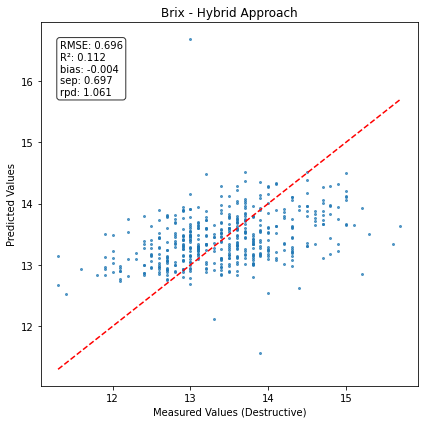

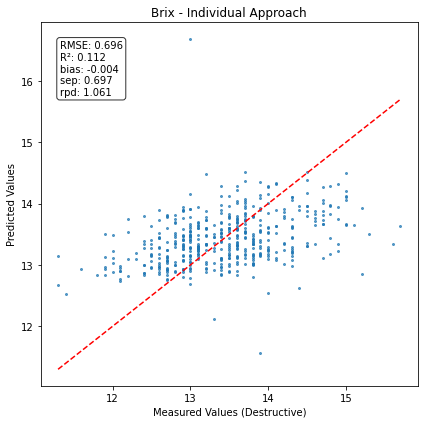

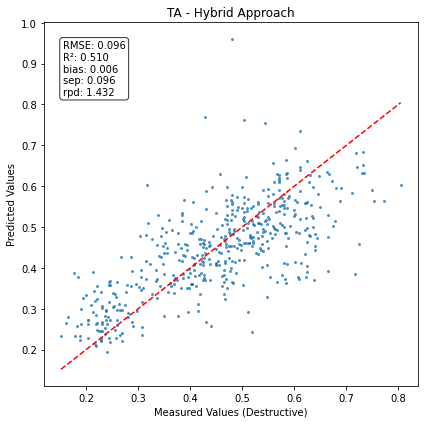

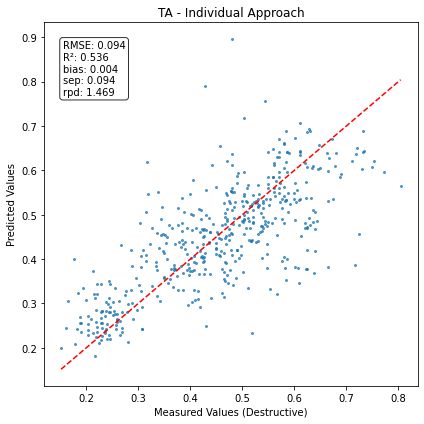

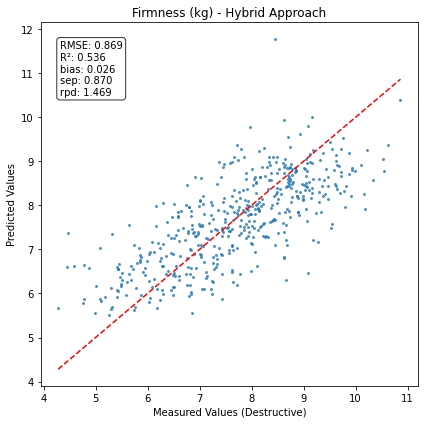

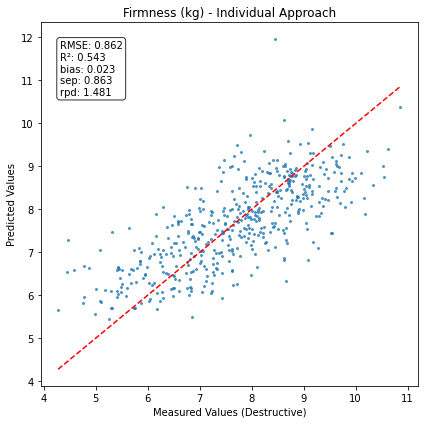

In [5]:
# Generate predictions for plotting
# Approach 1 (Hybrid) predictions
hybrid_pred_brix = pls_brix.predict(X_test_scaled).flatten()
hybrid_pred_ta = pls2.predict(X_test_scaled)[:, 0]  # First column is TA
hybrid_pred_firmness = pls2.predict(X_test_scaled)[:, 1]  # Second column is Firmness

# Approach 2 (Individual) predictions
ind_pred_brix = individual_models['Brix'].predict(X_test_scaled).flatten()
ind_pred_ta = individual_models['TA'].predict(X_test_scaled).flatten()
ind_pred_firmness = individual_models['Firmness (kg)'].predict(X_test_scaled).flatten()

# Create plots
print("\n=== Prediction Plots ===")
targets = ['Brix', 'TA', 'Firmness (kg)']
approaches = ['Hybrid', 'Individual']

for target in targets:
    for approach in approaches:
        # Get the correct predictions and true values
        if approach == 'Hybrid':
            if target == 'Brix':
                y_pred = hybrid_pred_brix
            elif target == 'TA':
                y_pred = hybrid_pred_ta
            else:  # Firmness
                y_pred = hybrid_pred_firmness
        else:  # Individual
            y_pred = individual_models[target].predict(X_test_scaled).flatten()
        
        y_true = y_test[target].values
        
        # Create plot
        plt.figure(figsize=(6, 6))
        plt.scatter(y_true, y_pred, s=4, alpha=0.7)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 
                 linestyle='--', color='red')
        plt.xlabel("Measured Values (Destructive)")
        plt.ylabel("Predicted Values")
        plt.title(f"{target} - {approach} Approach")
        
        # Add RMSE and R² to plot
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        n = y_true.shape[0]
        y_error = y_true - y_pred
        mean_error = np.mean(y_error)
        std_error = np.sqrt(np.square(y_error - mean_error).sum() / (n-1))
        std_true = np.sqrt(np.square(y_true - y_true.mean()).sum() / (n-1))
        rpd = std_true / std_error

        plt.text(0.05, 0.95, f"RMSE: {rmse:.3f}\nR²: {r2:.3f} \n"
                 f"bias: {mean_error:.3f}\n"
                 f"sep: {std_error:.3f}\n"
                 f"rpd: {rpd:.3f}",
                 transform=plt.gca().transAxes,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()